In [31]:
import re
from datetime import datetime
from os import path

import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
recordings_dir = '../recordings'
recording_name = '12Feb2024'
log_file_name = 'command line output.txt'

# path.join combines the parts of the file path
# path.abspath normalizes all slashes and provides the full absolute path
log_file = path.abspath(path.join(recordings_dir, recording_name, log_file_name))

print(f'Reading log file: {log_file}')

Reading log file: c:\Users\derek\Source\kiwi_tracker\recordings\12Feb2024\command line output.txt


In [44]:
# Initialize arrays to store data
dates = []
bpms = []
snrs = []
beep_durations = []

# Define the regular expression pattern to extract data
pattern = re.compile(r'  DATE : (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d+) \| BPM :  (\d+\.\d+) \|  SNR :  (\d+\.\d+)  \| BEEP_DURATION :  (\d+\.\d+) sec.*')

# Read the log file
with open(log_file, 'r') as file:
    # Process each line
    for line in file:
        # Match the pattern in each line
        match = pattern.match(line)
        if match:
            # Extract data from the matched groups
            date_str, bpm_str, snr_str, beep_duration_str = match.groups()

            # Convert strings to appropriate data types
            date = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S.%f')
            bpm = float(bpm_str)
            snr = float(snr_str)
            beep_duration = float(beep_duration_str)

            # Append data to arrays
            dates.append(date)
            bpms.append(bpm)
            snrs.append(snr)
            beep_durations.append(beep_duration)

print(f'Read {len(bpms)} beeps from the record')

Read 597 beeps from the record


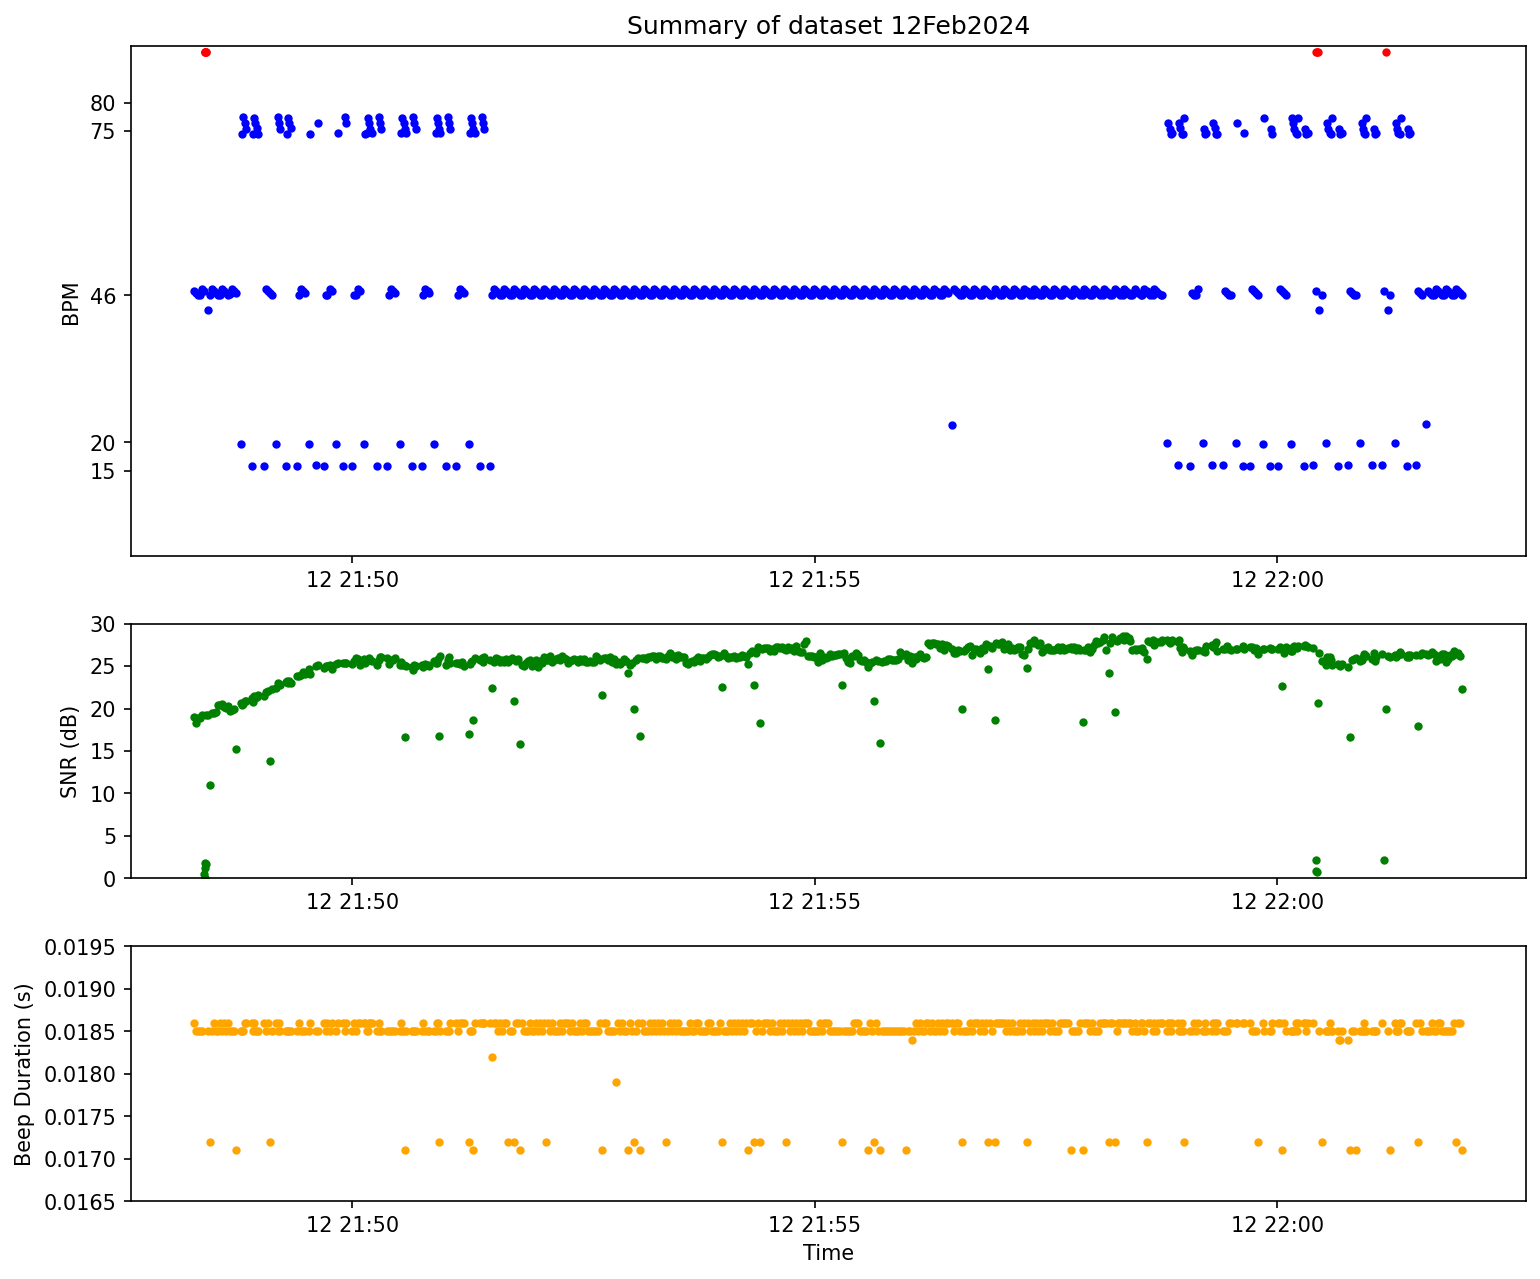

In [57]:
# Config
marker = '.' # 'o'
linewidth = 0.0

fig, axes = plt.subplots(3, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1, 1]}, dpi=150)
axes[0].set_title(f'Summary of dataset {recording_name}')

axes[0].plot(dates, bpms, label='BPMs', marker=marker, lw=linewidth, color='blue')

# Find and plot points off the chart
high_bpm_dates = [date for date, bpm in zip(dates, bpms) if bpm > 90]
axes[0].plot(high_bpm_dates, [89]*len(high_bpm_dates), label='Errors', marker=marker, lw=linewidth, color='red')


axes[0].set_ylabel("BPM")
axes[0].set_ylim([0, 90])
axes[0].set_yticks([15, 20, 46, 75, 80])

axes[1].plot(dates, snrs, label='SNRs', marker=marker, lw=linewidth, color='green')
axes[1].set_ylabel("SNR (dB)")
axes[1].set_ylim([0, 30])

axes[2].plot(dates, beep_durations, label='Beep Durations', marker=marker, lw=linewidth, color='orange')
axes[2].set_ylabel("Beep Duration (s)")
axes[2].set_ylim([0.0165, 0.0195])
axes[2].set_xlabel('Time')

#plt.grid(True)
#plt.show()

fig.savefig(path.abspath(path.join(recordings_dir, recording_name, f'{recording_name}_plots.pdf')), format='pdf', bbox_inches='tight')
fig.savefig(path.abspath(path.join(recordings_dir, recording_name, f'{recording_name}_plots.png')), format='png', bbox_inches='tight')